In [1]:
%matplotlib inline
# generic libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
from joblib import Parallel, delayed
import pickle
import time
import plotly.graph_objects as go

# machine learning
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, make_scorer
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.pipeline import make_pipeline
import optuna
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# path and files treatment
import glob
import os

# Variables


In [2]:
# env could be 'local' or 'kaggle'
env = 'kaggle'

if env == 'local':
    data_folder = './data'
    output = './output/'
    save_path = './img/'
    if not(os.path.exists(output)):
        os.makedirs(output)
    if not(os.path.exists(save_path)):
        os.makedirs(save_path)    

elif env == 'kaggle':
    data_folder = '../input/optiver-realized-volatility-prediction'
    output = './output/'
    save_path = './img/'
    os.makedirs(save_path)
    os.makedirs(output)
else:
    print('env variable must be defined')

bk_train_fol = '/book_train.parquet/'
td_train_fol = '/trade_train.parquet/'
bk_test_fol = '/book_test.parquet/'
td_test_fol = '/trade_test.parquet/'

model_final = 'finalized_model.sav'

RANDOM_SEED = 42


# if None take all the dataset
number_of_stocks = 5

pd.set_option('max_rows', 300)
pd.set_option('max_columns', 300)

## Functions


In [3]:
def load_df(df_folder, nb_stock_to_load=0, data_folder=data_folder):
    '''load a parquet 
    
    arguments
    ---------------
    data_folder (str)
    df_folder (str)
    nb_stock_to_load (int)
        number of subfolders to load
    '''
    stock_list = os.listdir(data_folder + df_folder)

    if nb_stock_to_load == 0:
        nb_stock_to_load = len(stock_list)
    nb_stock_to_load = min(nb_stock_to_load, len(stock_list))
    
    if nb_stock_to_load == 1:
        df = pd.read_parquet(data_folder + df_folder + '/stock_id=0')
        df['stock_id'] = 0
    else:
        ## depreciated
        # subset_paths = []
        # for stock in stock_list[:nb_stock_to_load]:
        #     subset_path = glob.glob(data_folder + df_folder + stock + '/*')
        #     subset_paths.append(subset_path[0])

        subset_paths = [glob.glob(data_folder + df_folder + stock + '/*')[0] for stock in stock_list[:nb_stock_to_load]]
        ## doesn't work
        # subset_paths = glob.glob(data_folder + df_folder + '/*')[:nb_stock_to_load]
        
        df = pd.read_parquet(subset_paths)
        df['stock_id'] = df['stock_id'].astype(int)
    return df

In [4]:
###############################
# Functions to add features
###############################

def add_wap(df, number=1, column_prefix='wap', standard=True):
    '''adding one wap

    number (int): the position of the price to take it could be 1 or 2
    standard (bool): use standard method to calculate wap or use a custom method
    '''
    if standard:
        df[column_prefix + str(number)] = (
            df['bid_price'+ str(number)] * df['ask_size'+ str(number)] + df['ask_price'+ str(number)] * df['bid_size'+ str(number)]) / (
                df['ask_size'+ str(number)]+ df['bid_size'+ str(number)])
    else:
        df[column_prefix + str(number) + '_ns'] = (
            df['bid_price'+ str(number)] * df['bid_size'+ str(number)] + df['ask_price'+ str(number)] * df['ask_size'+ str(number)]) / (
                df['ask_size'+ str(number)]+ df['bid_size'+ str(number)])

def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

def add_waps(df):
        '''add many waps'''
        add_wap(df, 1, column_prefix='wap')
        add_wap(df, 2, column_prefix='wap')
        add_wap(df, 1, column_prefix='wap', standard=False)
        add_wap(df, 2, column_prefix='wap', standard=False)
        df['wap_p'] = ((
                df['wap1'] * (df['ask_size1'] + df['bid_size1']) +
                df['wap2'] * (df['ask_size2'] + df['bid_size2'])) /
                (df['ask_size1'] + df['bid_size1'] + df['ask_size2'] + df['bid_size2']))
        df['wap_balance'] = abs(df['wap1'] - df['wap2'])

def add_log_return(df, price_col, log_col_name, group='time_id'):
        df[log_col_name] = df.groupby([group])[price_col].apply(log_return)

def add_spreads(df):
        # # tests with ponderates features
        # df['bid_spread_p'] = (df['bid_price1'] * df['bid_size1'] - df['bid_price2'] * df['bid_size1'])/(df['bid_size1'] + df['bid_size2'])
        # df['ask_spread_p'] = (df['ask_price1'] * df['ask_size1'] - df['ask_price2'] * df['ask_size1'])/(df['ask_size1'] + df['ask_size2'])
        # df["bid_ask_spread_p"] = abs(df['bid_spread_p'] - df['ask_spread_p'])
        df['bid_spread'] = df['bid_price1'] - df['bid_price2']
        df['ask_spread'] = df['ask_price1'] - df['ask_price2']
        df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1'])/2)
        df["bid_ask_spread1"] = (df['ask_price1'] - df['bid_price1'])/df['bid_price1']
        df["bid_ask_spread2"] = (df['ask_price2'] - df['bid_price2'])/df['bid_price2']
        df["bid_ask_spread_p"] = ((df['ask_price1'] + df['ask_price2']) - (df['bid_price1'] + df['bid_price2']))/(df['bid_price1'] + df['bid_price2'])

def add_volumes(df):
        df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
        df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))

def add_EMA(df, wap_col, nb_period):
        df[wap_col + '_' + str(nb_period) + 'sec_EWM'] = df[wap_col].ewm(span=nb_period, adjust=False).mean()

###############################
# Evaluation
###############################
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

## Book train


In [5]:
book_train = load_df(bk_train_fol, nb_stock_to_load=1)
book_train.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0


In [6]:
book_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917553 entries, 0 to 917552
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   time_id            917553 non-null  int16  
 1   seconds_in_bucket  917553 non-null  int16  
 2   bid_price1         917553 non-null  float32
 3   ask_price1         917553 non-null  float32
 4   bid_price2         917553 non-null  float32
 5   ask_price2         917553 non-null  float32
 6   bid_size1          917553 non-null  int32  
 7   ask_size1          917553 non-null  int32  
 8   bid_size2          917553 non-null  int32  
 9   ask_size2          917553 non-null  int32  
 10  stock_id           917553 non-null  int64  
dtypes: float32(4), int16(2), int32(4), int64(1)
memory usage: 38.5 MB


## Trade train


In [7]:
# Test tp know if the book and trade data are on same stocks
os.listdir(data_folder + td_train_fol) == os.listdir(data_folder + bk_train_fol)

True

In [8]:
trade_train = load_df(td_train_fol, nb_stock_to_load=2)

In [9]:
trade_train.head()

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,10,1.000942,100,1,97
1,5,43,1.001984,234,5,97
2,5,45,1.002558,101,4,97
3,5,64,1.002685,107,5,97
4,5,83,1.003211,3,1,97


## Book/Trade test

These file are here just to show the shape and firsts value of the hidden 10 min window.


In [10]:
book_test = load_df(bk_test_fol)
book_test.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,4,0,1.000049,1.000590,0.999656,1.000639,91,100,100,24,0
1,4,1,1.000049,1.000590,0.999656,1.000639,91,100,100,20,0
2,4,5,1.000049,1.000639,0.999656,1.000885,290,20,101,15,0


In [11]:
trade_test = load_df(td_test_fol)
trade_test.head()

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,4,7,1.000344,1,1,0
1,4,24,1.000049,100,7,0
2,4,27,1.000059,100,3,0


## Targets / realized volatility


In [12]:
# this dataset is just a sample, it will be replaced by the real one at each submission.
vol_test = pd.read_csv(data_folder +'/test.csv')
vol_test

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [13]:
vol_train = pd.read_csv(data_folder +'/train.csv')
vol_train.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [14]:
vol_train.shape

(428932, 3)

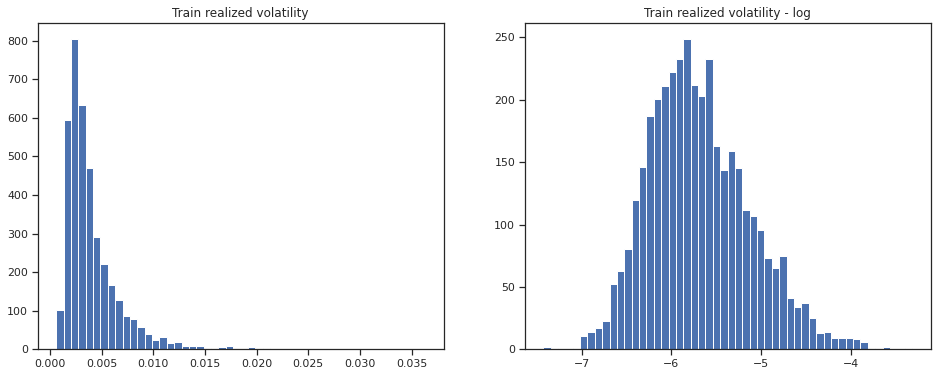

In [15]:
vol_stock0 = vol_train[vol_train['stock_id'] == 0]

sns.set_theme(style="ticks")
fig = plt.figure(figsize=(16, 6))
# fig.suptitle('Images after equalization preprocessing', fontsize=16)
# fig.tight_layout()

plt.subplot(1, 2, 1)
plt.title("Train realized volatility")
plt.hist(vol_stock0['target'], bins=50)

plt.subplot(1, 2, 2)
plt.title("Train realized volatility - log")
plt.hist(np.log(vol_stock0['target']), bins=50)

if env == 'local' or env == 'kaggle':
    plt.savefig(save_path + 'realized_volatility.png')

plt.show()

# Preprocessing & baseline

---


## Functions


In [16]:
# Create a list of stocks paths books from the dataset
if number_of_stocks is None:
    list_order_book_file_train = glob.glob(data_folder + bk_train_fol + '*')
    list_order_trade_file_train = glob.glob(data_folder + td_train_fol + '*')
    stock_id_max = max([int(path.split('=')[1]) for path in list_order_trade_file_train]) # files on kaggle are random sorted
else:
    stock_id_max = number_of_stocks-1 # stocks start at 0
    list_order_book_file_train = [path for path in glob.glob(data_folder + bk_train_fol + '*') if int(path.split('=')[1]) <= stock_id_max]
    list_order_trade_file_train = [path for path in glob.glob(data_folder + td_train_fol + '*') if int(path.split('=')[1]) <= stock_id_max]


## Naive RMSPE

A well-known fact about volatility is that it tends to be autocorrelated. We can use this property to implement a naive model that simply "predicts" the realized volatility using the realized volatility over the first 10 minutes.

Let's calculate the realized volatility of the first part of the window on the train dataset.

In [17]:
# select all stocks books
list_order_book_file_train = glob.glob(data_folder + bk_train_fol + '/*')
list_order_book_file_train[:10]

['../input/optiver-realized-volatility-prediction/book_train.parquet/stock_id=97',
 '../input/optiver-realized-volatility-prediction/book_train.parquet/stock_id=43',
 '../input/optiver-realized-volatility-prediction/book_train.parquet/stock_id=21',
 '../input/optiver-realized-volatility-prediction/book_train.parquet/stock_id=72',
 '../input/optiver-realized-volatility-prediction/book_train.parquet/stock_id=4',
 '../input/optiver-realized-volatility-prediction/book_train.parquet/stock_id=112',
 '../input/optiver-realized-volatility-prediction/book_train.parquet/stock_id=22',
 '../input/optiver-realized-volatility-prediction/book_train.parquet/stock_id=105',
 '../input/optiver-realized-volatility-prediction/book_train.parquet/stock_id=116',
 '../input/optiver-realized-volatility-prediction/book_train.parquet/stock_id=63']

In [18]:
list_order_trade_file_train = glob.glob(data_folder + td_train_fol + '/*')
list_order_trade_file_train[:10]

['../input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=97',
 '../input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=43',
 '../input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=21',
 '../input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=72',
 '../input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=4',
 '../input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=112',
 '../input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=22',
 '../input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=105',
 '../input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=116',
 '../input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=63']

In [19]:
# specific for naive model
def realized_volatility_per_time_id(file_path, prediction_column_name):
    '''load datas of one stock_id then calculate WAP, log_return
    set a new DF and put inside realized_volatility per time_id
    add a column with competition form : {stock_id}-{time_id} called row_id

    file_path : path of subfolders with stock_id
        example : ./data/book_train/stock_id=0
    prediction_column_name : name of the realized_volatility column
    
    return row_id, prediction_name columns'''
    df_book_data = pd.read_parquet(file_path)
    add_wap(df_book_data)

    df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap1'].apply(log_return)
    df_book_data = df_book_data[~df_book_data['log_return'].isnull()] # removing each Nan of firsts time_id, ~ : invers the mask

    df_realized_vol_per_stock =  pd.DataFrame(df_book_data.groupby(['time_id'])['log_return'].agg(realized_volatility)).reset_index()
    df_realized_vol_per_stock = df_realized_vol_per_stock.rename(columns = {'log_return':prediction_column_name})
    
    stock_id = file_path.split('=')[1]
    df_realized_vol_per_stock['row_id'] = df_realized_vol_per_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    
    return df_realized_vol_per_stock[['row_id',prediction_column_name]]



def past_realized_volatility_per_stock(list_file,prediction_column_name):
    df_past_realized = pd.DataFrame()
    for file in list_file:
        df_past_realized = pd.concat([df_past_realized,
                                     realized_volatility_per_time_id(file,prediction_column_name)])
    return df_past_realized

In [20]:
# It takes too much time for all stocks 

df_past_realized_train = past_realized_volatility_per_stock(list_file=list_order_book_file_train[:2],
                                                            prediction_column_name='pred')
df_past_realized_train.head()

,row_id,pred
0,97-5,0.007263
1,97-11,0.002919
2,97-16,0.003799
3,97-31,0.003753
4,97-62,0.004365


In [21]:
df_naive = vol_train.copy()
# Let's join the output dataframe with train.csv to see the performance of the naive prediction on training set.
# naive prediction = predict same volatility in the next 10min window (auto realisation)
df_naive['row_id'] = df_naive['stock_id'].astype(str) + '-' + df_naive['time_id'].astype(str)
df_naive = df_naive[['row_id','target']]
df_naive = df_naive.merge(df_past_realized_train[['row_id','pred']], on = ['row_id'], how = 'right')
df_naive.head()

,row_id,target,pred
0,97-5,0.006254,0.007263
1,97-11,0.002656,0.002919
2,97-16,0.003712,0.003799
3,97-31,0.005743,0.003753
4,97-62,0.005345,0.004365


In [22]:
R2 = round(r2_score(y_true = df_naive['target'], y_pred = df_naive['pred']),3)
RMSPE = round(rmspe(y_true = df_naive['target'], y_pred = df_naive['pred']),3)
print(f'Performance of the naive prediction: R2 score: {R2}, RMSPE: {RMSPE}')

Performance of the naive prediction: R2 score: 0.763, RMSPE: 0.294


## Order book train


**Process flow**  
<br>
<img src="https://github.com/abugeia/P8_kaggle_competition/blob/master/img/p8_process_orders.png?raw=true" width="900px"><br>


In [23]:
# list of waps for applying log return, EMA and EMA log return
# this list is also used in the creation of aggregation dic
waps = ['wap1', 'wap2', 'wap1_ns', 'wap2_ns', 'wap_p']

def book_feature_eng_per_stock(file_path, waps=waps):
    ''' Load datas of one stock_id then adding features.
    Removing Nan rows of theses features
    
    file_path : path of subfolders with stock_id
        example : ./data/book_train/stock_id=0

    return the df '''
    book_train = pd.read_parquet(file_path)

    add_waps(book_train)
    
    for wap in waps:
        add_log_return(book_train, price_col=wap, log_col_name=wap + '_log_return')
        for period in  [20, 100]:
            add_EMA(book_train, wap, period)
            EMA_col_name = wap + '_' + str(period) + 'sec_EWM'
            add_log_return(book_train, price_col=EMA_col_name, log_col_name=EMA_col_name + '_log_return')
            book_train['diff_' + EMA_col_name] = abs(book_train[wap] - book_train[EMA_col_name])
    
    add_spreads(book_train)
    add_volumes(book_train)

    # book_train = book_train[~(book_train['wap1_log_return'].isnull() | book_train['log_return2'].isnull() | book_train['log_return_p'].isnull())] # at the end ?
    book_train = book_train.fillna(book_train.median())
    
    return book_train

In [24]:
# sample with stock 0
df_sample = book_feature_eng_per_stock(list_order_book_file_train[0])
df_sample.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,wap1,wap2,wap1_ns,wap2_ns,wap_p,wap_balance,wap1_log_return,wap1_20sec_EWM,wap1_20sec_EWM_log_return,diff_wap1_20sec_EWM,wap1_100sec_EWM,wap1_100sec_EWM_log_return,diff_wap1_100sec_EWM,wap2_log_return,wap2_20sec_EWM,wap2_20sec_EWM_log_return,diff_wap2_20sec_EWM,wap2_100sec_EWM,wap2_100sec_EWM_log_return,diff_wap2_100sec_EWM,wap1_ns_log_return,wap1_ns_20sec_EWM,wap1_ns_20sec_EWM_log_return,diff_wap1_ns_20sec_EWM,wap1_ns_100sec_EWM,wap1_ns_100sec_EWM_log_return,diff_wap1_ns_100sec_EWM,wap2_ns_log_return,wap2_ns_20sec_EWM,wap2_ns_20sec_EWM_log_return,diff_wap2_ns_20sec_EWM,wap2_ns_100sec_EWM,wap2_ns_100sec_EWM_log_return,diff_wap2_ns_100sec_EWM,wap_p_log_return,wap_p_20sec_EWM,wap_p_20sec_EWM_log_return,diff_wap_p_20sec_EWM,wap_p_100sec_EWM,wap_p_100sec_EWM_log_return,diff_wap_p_100sec_EWM,bid_spread,ask_spread,price_spread,bid_ask_spread1,bid_ask_spread2,bid_ask_spread_p,total_volume,volume_imbalance
0,5,0,1.000135,1.002019,1.000096,1.002596,200,202,200,1,1.001072,1.002583,1.001082,1.000109,1.001576,0.001511,0.000000,1.001072,4.145170e-07,0.000000,1.001072,1.181428e-07,0.000000,0.000000,1.002583,2.427287e-07,0.000000,1.002583,1.107895e-07,0.000000,0.000000,1.001082,2.702212e-07,0.000000,1.001082,1.223759e-07,0.000000,0.000000,1.000109,4.682031e-09,0.000000,1.000109,1.268915e-07,0.000000,0.000000,1.001576,4.394554e-07,0.000000,1.001576,1.087555e-07,0.000000,0.000038,-0.000577,0.001882,0.001884,0.002499,0.002192,603,197
1,5,1,1.000135,1.002019,1.000096,1.002596,300,324,100,1,1.001041,1.002571,1.001113,1.000121,1.001254,0.001531,-0.000032,1.001069,-3.001730e-06,0.000029,1.001072,-6.241214e-07,0.000031,-0.000012,1.002582,-1.169663e-06,0.000011,1.002583,-2.431972e-07,0.000012,0.000032,1.001085,3.001693e-06,0.000029,1.001082,6.241151e-07,0.000031,0.000012,1.000110,1.172556e-06,0.000011,1.000109,2.437989e-07,0.000012,-0.000322,1.001545,-3.062892e-05,0.000291,1.001570,-6.368312e-06,0.000316,0.000038,-0.000577,0.001882,0.001884,0.002499,0.002192,725,75
2,5,2,1.000135,1.001981,1.000096,1.002019,200,100,100,121,1.001365,1.000966,1.000750,1.001149,1.001196,0.000399,0.000324,1.001097,2.816945e-05,0.000268,1.001077,5.809986e-06,0.000288,-0.001602,1.002428,-1.535225e-04,0.001462,1.002551,-3.193689e-05,0.001585,-0.000363,1.001053,-3.183306e-05,0.000303,1.001076,-6.571606e-06,0.000326,0.001027,1.000209,9.895289e-05,0.000940,1.000129,2.059358e-05,0.001020,-0.000058,1.001512,-3.321001e-05,0.000316,1.001562,-7.385199e-06,0.000366,0.000038,-0.000039,0.001844,0.001846,0.001923,0.001884,521,79
3,5,3,1.000173,1.001981,1.000135,1.002019,100,102,100,121,1.001068,1.000987,1.001086,1.001166,1.001026,0.000081,-0.000297,1.001095,-2.802176e-06,0.000027,1.001077,-1.869571e-07,0.000009,0.000021,1.002291,-1.369246e-04,0.001304,1.002520,-3.089035e-05,0.001533,0.000336,1.001056,3.151173e-06,0.000030,1.001076,2.020395e-07,0.000010,0.000017,1.000300,9.117406e-05,0.000866,1.000150,2.052926e-05,0.001016,-0.000170,1.001466,-4.623626e-05,0.000440,1.001552,-1.060460e-05,0.000526,0.000039,-0.000039,0.001806,0.001807,0.001884,0.001846,423,23
4,5,4,1.000135,1.001981,1.000096,1.002019,200,102,100,121,1.001357,1.000966,1.000758,1.001149,1.001192,0.000391,0.000289,1.001120,2.497759e-05,0.000238,1.001083,5.537397e-06,0.000274,-0.000021,1.002165,-1.258976e-04,0.001199,1.002489,-3.069472e-05,0.001523,-0.000327,1.001027,-2.832685e-05,0.000269,1.001069,-6.284304e-06,0.000311,-0.000017,1.000381,8.083010e-05,0.000768,1.000170,1.977845e-05,0.000979,0.000166,1.001440,-2.603182e-05,0.000248,1.001544,-7.109343e-06,0.000352,0.000038,-0.000039,0.001844,0.001846,0.001923,0.001884,523,77


In [25]:
# list of spreads to apply the aggregate functions
spreads = ['bid_ask_spread1', 'bid_ask_spread2', 'bid_ask_spread_p', 'bid_spread', 'ask_spread', 'price_spread']

#########################################
# Creation of order book aggregation dic
#########################################
bk_feature_dic = {}
for wap in waps:
    bk_feature_dic[wap + '_log_return'] = [realized_volatility]
    # bk_feature_dic[wap] = [np.std, pd.Series.mad]
    for period in [20, 100]:
        EMA_col_name = wap + '_' + str(period) + 'sec_EWM'
        # bk_feature_dic[EMA_col_name + '_log_return'] = [realized_volatility]
        bk_feature_dic['diff_' + EMA_col_name] = [np.sum, np.std]
for spread in spreads:
    bk_feature_dic[spread] = [np.sum, np.std]

bk_feature_dic['total_volume'] = [np.sum, np.mean]
bk_feature_dic['volume_imbalance'] = [np.std]
bk_feature_dic['wap_balance'] = [np.sum, np.mean]

bk_feature_dic

{'wap1_log_return': [<function __main__.realized_volatility(series_log_return)>],
 'diff_wap1_20sec_EWM': [<function numpy.sum(a, axis=None, dtype=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>,
  <function numpy.std(a, axis=None, dtype=None, out=None, ddof=0, keepdims=<no value>)>],
 'diff_wap1_100sec_EWM': [<function numpy.sum(a, axis=None, dtype=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>,
  <function numpy.std(a, axis=None, dtype=None, out=None, ddof=0, keepdims=<no value>)>],
 'wap2_log_return': [<function __main__.realized_volatility(series_log_return)>],
 'diff_wap2_20sec_EWM': [<function numpy.sum(a, axis=None, dtype=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>,
  <function numpy.std(a, axis=None, dtype=None, out=None, ddof=0, keepdims=<no value>)>],
 'diff_wap2_100sec_EWM': [<function numpy.sum(a, axis=None, dtype=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>

In [26]:
def book_agg_form_parallele(file):
    ''' Create a new df that aggregate data by time_id and apply the feature dic
    add :
    - a stock_id columns
    - a competition form column : {stock_id}-{time_id} called row_id
    return the new df
    '''
    stock_id = file.split('=')[1]
    df_agg_stock = book_feature_eng_per_stock(file)
    df_agg_stock = pd.DataFrame(df_agg_stock.groupby(['time_id']).agg(bk_feature_dic).reset_index())

    df_agg_stock.columns = ['_'.join(col).rstrip('_') for col in df_agg_stock.columns.values]
    df_agg_stock['row_id'] = df_agg_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    # df_agg_stock['stock_id'] = stock_id
    df_agg_stock.drop('time_id', axis=1, inplace=True)

    return df_agg_stock

In [27]:
def agg_df_and_concatenate_parallel(paths_list, func):
    ''' Create an concateneted df of preprocessed stocks df by the func'''

    df_agg = Parallel(n_jobs=-1)(
        delayed(func)(file) 
        for file in paths_list)
    
    df_agg = pd.concat(df_agg, ignore_index = True)

    return df_agg

In [28]:
%%time
df_order_agg = agg_df_and_concatenate_parallel(list_order_book_file_train[:2], book_agg_form_parallele)
df_order_agg.head()

CPU times: user 91.5 ms, sys: 83.2 ms, total: 175 ms
Wall time: 39.1 s


,wap1_log_return_realized_volatility,diff_wap1_20sec_EWM_sum,diff_wap1_20sec_EWM_std,diff_wap1_100sec_EWM_sum,diff_wap1_100sec_EWM_std,wap2_log_return_realized_volatility,diff_wap2_20sec_EWM_sum,diff_wap2_20sec_EWM_std,diff_wap2_100sec_EWM_sum,diff_wap2_100sec_EWM_std,wap1_ns_log_return_realized_volatility,diff_wap1_ns_20sec_EWM_sum,diff_wap1_ns_20sec_EWM_std,diff_wap1_ns_100sec_EWM_sum,diff_wap1_ns_100sec_EWM_std,wap2_ns_log_return_realized_volatility,diff_wap2_ns_20sec_EWM_sum,diff_wap2_ns_20sec_EWM_std,diff_wap2_ns_100sec_EWM_sum,diff_wap2_ns_100sec_EWM_std,wap_p_log_return_realized_volatility,diff_wap_p_20sec_EWM_sum,diff_wap_p_20sec_EWM_std,diff_wap_p_100sec_EWM_sum,diff_wap_p_100sec_EWM_std,bid_ask_spread1_sum,bid_ask_spread1_std,bid_ask_spread2_sum,bid_ask_spread2_std,bid_ask_spread_p_sum,bid_ask_spread_p_std,bid_spread_sum,bid_spread_std,ask_spread_sum,ask_spread_std,price_spread_sum,price_spread_std,total_volume_sum,total_volume_mean,volume_imbalance_std,wap_balance_sum,wap_balance_mean,row_id
0,0.007263,0.146303,0.000420,0.274399,0.000807,0.012585,0.191627,0.000542,0.314903,0.000804,0.008643,0.147078,0.000465,0.254380,0.000857,0.010847,0.173970,0.000611,0.306562,0.001029,0.007990,0.138179,0.000439,0.274364,0.000749,0.422247,0.000389,0.569156,0.000640,0.495690,0.000457,0.048495,0.000278,-0.098261,0.000393,0.421913,0.000388,118424,415.522807,108.259034,0.205782,0.000722,97-5
1,0.002919,0.066503,0.000275,0.129559,0.000334,0.005377,0.077122,0.000246,0.126430,0.000373,0.002599,0.048111,0.000256,0.100007,0.000310,0.005923,0.087057,0.000335,0.114985,0.000354,0.002823,0.064529,0.000237,0.118892,0.000319,0.195123,0.000216,0.272412,0.000244,0.233766,0.000214,0.030290,0.000121,-0.046888,0.000166,0.195038,0.000216,83580,346.804979,135.441451,0.096073,0.000399,97-11
2,0.003799,0.090183,0.000332,0.166598,0.000374,0.006038,0.116412,0.000367,0.194114,0.000456,0.004054,0.088901,0.000345,0.157622,0.000450,0.005771,0.100851,0.000353,0.146179,0.000453,0.003888,0.095898,0.000333,0.178174,0.000383,0.174843,0.000238,0.284401,0.000341,0.229612,0.000260,0.059152,0.000182,-0.050283,0.000200,0.174782,0.000238,144777,500.958478,295.533830,0.077268,0.000267,97-16
3,0.003753,0.070969,0.000282,0.098221,0.000390,0.007352,0.095455,0.000309,0.118228,0.000404,0.005619,0.095409,0.000359,0.157294,0.000416,0.007742,0.109555,0.000415,0.159722,0.000537,0.004224,0.066110,0.000257,0.097760,0.000331,0.252483,0.000419,0.389376,0.000587,0.320917,0.000470,0.048572,0.000226,-0.088110,0.000290,0.252322,0.000418,88588,393.724444,140.207786,0.126249,0.000561,97-31
4,0.004365,0.058954,0.000258,0.086390,0.000363,0.006709,0.071939,0.000404,0.113838,0.000447,0.006307,0.090235,0.000420,0.126327,0.000595,0.006824,0.081547,0.000361,0.107275,0.000519,0.004028,0.058798,0.000261,0.095513,0.000334,0.227878,0.000566,0.321658,0.000646,0.274759,0.000570,0.043546,0.000243,-0.049991,0.000306,0.227696,0.000565,86193,516.125749,98.150079,0.082689,0.000495,97-62


---

## Trades book train


**Process flow**  
<br>
<img src="https://github.com/abugeia/P8_kaggle_competition/blob/master/img/p8_process_trades.png?raw=true" width="900px"><br>


In [29]:
###############################
# Functions to add features
###############################
def add_amount(df):
    df['amount'] = df['price'] * df['size']
def add_power(df):
    df['power'] = (df['price'] - df['price'].shift(1))/df['price']*df['size']

# Function to count unique elements of a series
def count_unique(series):
    return len(np.unique(series))

In [30]:
def trade_feature_eng_per_stock(file_path):
    ''' Load datas of one stock_id then adding features.
    Removing Nan rows of theses features
    
    file_path : path of subfolders with stock_id
        example : ./data/trade_train/stock_id=0

    return the df '''
    df = pd.read_parquet(file_path)
        
    add_log_return(df, price_col='price', log_col_name='td_log_return')

    add_amount(df)
    for period in  [20, 100]:
        add_EMA(df, 'amount', period)
        EMA_col_name = 'amount_' + str(period) + 'sec_EWM'
        add_log_return(df, price_col=EMA_col_name, log_col_name=EMA_col_name + '_log_return')
        
    df['diff_td'] = df.seconds_in_bucket.diff() # same Nan as log_return
    df['amount_p_order'] = df.amount / df.order_count
    add_power(df)

    df = df[~df['td_log_return'].isnull()]
    return df

In [31]:
# sample with stock 0
df_sample = trade_feature_eng_per_stock(list_order_trade_file_train[0])
df_sample.head()

,time_id,seconds_in_bucket,price,size,order_count,td_log_return,amount,amount_20sec_EWM,amount_20sec_EWM_log_return,amount_100sec_EWM,amount_100sec_EWM_log_return,diff_td,amount_p_order,power
1,5,43,1.001984,234,5,0.001040,234.464256,112.891369,0.120314,102.755016,0.026236,33.0,46.892851,0.243291
2,5,45,1.002558,101,4,0.000573,101.258345,111.783462,-0.009862,102.725379,-0.000288,2.0,25.314586,0.057813
3,5,64,1.002685,107,5,0.000127,107.287302,111.355256,-0.003838,102.815714,0.000879,19.0,21.457460,0.013574
4,5,83,1.003211,3,1,0.000525,3.009634,101.036626,-0.097243,100.839356,-0.019409,19.0,3.009634,0.001574
5,5,85,1.002635,203,7,-0.000575,203.534881,110.798364,0.092229,102.872931,0.019966,2.0,29.076412,-0.116697


In [32]:
#########################################
# Creation of order book aggregation dic
#########################################
td_feature_dic = {}
for period in  [20, 100]:
    EMA_col_name = 'amount_' + str(period) + 'sec_EWM_log_return'
    td_feature_dic[EMA_col_name] = [realized_volatility]
td_feature_dic['td_log_return'] = [realized_volatility]
# td_feature_dic['seconds_in_bucket'] = [count_unique] # removed after feature importance analysis
td_feature_dic['diff_td'] = [np.std]
td_feature_dic['amount_p_order'] = [np.mean]
td_feature_dic['price'] = [np.mean]
td_feature_dic['amount'] = [np.std, pd.Series.mad]
td_feature_dic['amount_p_order'] = [np.mean, np.sum]
# td_feature_dic['size'] = [np.mean, np.sum] # removed after feature importance analysis
td_feature_dic['order_count'] = [np.mean, np.sum]

td_feature_dic

{'amount_20sec_EWM_log_return': [<function __main__.realized_volatility(series_log_return)>],
 'amount_100sec_EWM_log_return': [<function __main__.realized_volatility(series_log_return)>],
 'td_log_return': [<function __main__.realized_volatility(series_log_return)>],
 'diff_td': [<function numpy.std(a, axis=None, dtype=None, out=None, ddof=0, keepdims=<no value>)>],
 'amount_p_order': [<function numpy.mean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>,
  <function numpy.sum(a, axis=None, dtype=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>],
 'price': [<function numpy.mean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>],
 'amount': [<function numpy.std(a, axis=None, dtype=None, out=None, ddof=0, keepdims=<no value>)>,
  <function pandas.core.generic.NDFrame._add_numeric_operations.<locals>.mad(self, axis=None, skipna=None, level=None)>],
 'order_count': [<function numpy.mean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>,


In [33]:
def trade_agg_form_parallele(file):
    ''' Create a new df that aggregate data by time_id
    add :
    - a stock_id columns
    - a with competition form column : {stock_id}-{time_id} called row_id
    return the new df
    '''
    stock_id = file.split('=')[1]
    df_agg_stock = trade_feature_eng_per_stock(file)
    df_agg_stock = pd.DataFrame(df_agg_stock.groupby(['time_id']).agg(td_feature_dic)).reset_index()
    
    df_agg_stock.columns = ['_'.join(col).rstrip('_') for col in df_agg_stock.columns.values]
    df_agg_stock['row_id'] = df_agg_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    # df_agg_stock['stock_id'] = stock_id
    df_agg_stock.drop('time_id', axis=1, inplace=True)

    return df_agg_stock


In [34]:
%%time
df_trade_agg = agg_df_and_concatenate_parallel(list_order_trade_file_train[:2], trade_agg_form_parallele)
df_trade_agg.head()

CPU times: user 35.8 ms, sys: 3.05 ms, total: 38.8 ms
Wall time: 12.1 s


,amount_20sec_EWM_log_return_realized_volatility,amount_100sec_EWM_log_return_realized_volatility,td_log_return_realized_volatility,diff_td_std,amount_p_order_mean,amount_p_order_sum,price_mean,amount_std,amount_mad,order_count_mean,order_count_sum,row_id
0,0.644652,0.131968,0.004278,16.484140,27.392197,1040.903442,1.001283,111.925492,83.106712,3.447368,131.0,97-5
1,0.753227,0.150204,0.001639,25.865840,14.503800,348.091217,0.999108,156.253897,92.918365,3.583333,86.0,97-11
2,1.460146,0.280070,0.002517,12.963660,54.467304,2777.832520,0.999860,179.858867,115.586800,2.117647,108.0,97-16
3,0.497730,0.148103,0.002241,19.761663,27.598328,689.958191,0.999670,177.576791,134.469025,4.200000,105.0,97-31
4,0.331848,0.080810,0.002836,25.141495,33.695877,606.525757,0.999190,131.474313,99.819061,3.611111,65.0,97-62


---

## Final DF train


In [35]:
def process_final_df(df_order_agg, df_trade_agg, df_target):
    '''select the targets of the chosen stocks
    merge target df to order and trades df
    return new df'''

    df = df_target.copy()
    #  adding the same index in our books df to merge
    df['row_id'] = df['stock_id'].astype(str) + '-' + df['time_id'].astype(str)

    df = df.merge(df_order_agg, on = ['row_id'], how = 'right')
    df = df.merge(df_trade_agg, on = ['row_id'], how = 'right')

    return df    

In [36]:
df_train = process_final_df(df_order_agg, df_trade_agg, vol_train)
df_train.head()

,stock_id,time_id,target,row_id,wap1_log_return_realized_volatility,diff_wap1_20sec_EWM_sum,diff_wap1_20sec_EWM_std,diff_wap1_100sec_EWM_sum,diff_wap1_100sec_EWM_std,wap2_log_return_realized_volatility,diff_wap2_20sec_EWM_sum,diff_wap2_20sec_EWM_std,diff_wap2_100sec_EWM_sum,diff_wap2_100sec_EWM_std,wap1_ns_log_return_realized_volatility,diff_wap1_ns_20sec_EWM_sum,diff_wap1_ns_20sec_EWM_std,diff_wap1_ns_100sec_EWM_sum,diff_wap1_ns_100sec_EWM_std,wap2_ns_log_return_realized_volatility,diff_wap2_ns_20sec_EWM_sum,diff_wap2_ns_20sec_EWM_std,diff_wap2_ns_100sec_EWM_sum,diff_wap2_ns_100sec_EWM_std,wap_p_log_return_realized_volatility,diff_wap_p_20sec_EWM_sum,diff_wap_p_20sec_EWM_std,diff_wap_p_100sec_EWM_sum,diff_wap_p_100sec_EWM_std,bid_ask_spread1_sum,bid_ask_spread1_std,bid_ask_spread2_sum,bid_ask_spread2_std,bid_ask_spread_p_sum,bid_ask_spread_p_std,bid_spread_sum,bid_spread_std,ask_spread_sum,ask_spread_std,price_spread_sum,price_spread_std,total_volume_sum,total_volume_mean,volume_imbalance_std,wap_balance_sum,wap_balance_mean,amount_20sec_EWM_log_return_realized_volatility,amount_100sec_EWM_log_return_realized_volatility,td_log_return_realized_volatility,diff_td_std,amount_p_order_mean,amount_p_order_sum,price_mean,amount_std,amount_mad,order_count_mean,order_count_sum
0,97,5,0.006254,97-5,0.007263,0.146303,0.000420,0.274399,0.000807,0.012585,0.191627,0.000542,0.314903,0.000804,0.008643,0.147078,0.000465,0.254380,0.000857,0.010847,0.173970,0.000611,0.306562,0.001029,0.007990,0.138179,0.000439,0.274364,0.000749,0.422247,0.000389,0.569156,0.000640,0.495690,0.000457,0.048495,0.000278,-0.098261,0.000393,0.421913,0.000388,118424,415.522807,108.259034,0.205782,0.000722,0.644652,0.131968,0.004278,16.484140,27.392197,1040.903442,1.001283,111.925492,83.106712,3.447368,131.0
1,97,11,0.002656,97-11,0.002919,0.066503,0.000275,0.129559,0.000334,0.005377,0.077122,0.000246,0.126430,0.000373,0.002599,0.048111,0.000256,0.100007,0.000310,0.005923,0.087057,0.000335,0.114985,0.000354,0.002823,0.064529,0.000237,0.118892,0.000319,0.195123,0.000216,0.272412,0.000244,0.233766,0.000214,0.030290,0.000121,-0.046888,0.000166,0.195038,0.000216,83580,346.804979,135.441451,0.096073,0.000399,0.753227,0.150204,0.001639,25.865840,14.503800,348.091217,0.999108,156.253897,92.918365,3.583333,86.0
2,97,16,0.003712,97-16,0.003799,0.090183,0.000332,0.166598,0.000374,0.006038,0.116412,0.000367,0.194114,0.000456,0.004054,0.088901,0.000345,0.157622,0.000450,0.005771,0.100851,0.000353,0.146179,0.000453,0.003888,0.095898,0.000333,0.178174,0.000383,0.174843,0.000238,0.284401,0.000341,0.229612,0.000260,0.059152,0.000182,-0.050283,0.000200,0.174782,0.000238,144777,500.958478,295.533830,0.077268,0.000267,1.460146,0.280070,0.002517,12.963660,54.467304,2777.832520,0.999860,179.858867,115.586800,2.117647,108.0
3,97,31,0.005743,97-31,0.003753,0.070969,0.000282,0.098221,0.000390,0.007352,0.095455,0.000309,0.118228,0.000404,0.005619,0.095409,0.000359,0.157294,0.000416,0.007742,0.109555,0.000415,0.159722,0.000537,0.004224,0.066110,0.000257,0.097760,0.000331,0.252483,0.000419,0.389376,0.000587,0.320917,0.000470,0.048572,0.000226,-0.088110,0.000290,0.252322,0.000418,88588,393.724444,140.207786,0.126249,0.000561,0.497730,0.148103,0.002241,19.761663,27.598328,689.958191,0.999670,177.576791,134.469025,4.200000,105.0
4,97,62,0.005345,97-62,0.004365,0.058954,0.000258,0.086390,0.000363,0.006709,0.071939,0.000404,0.113838,0.000447,0.006307,0.090235,0.000420,0.126327,0.000595,0.006824,0.081547,0.000361,0.107275,0.000519,0.004028,0.058798,0.000261,0.095513,0.000334,0.227878,0.000566,0.321658,0.000646,0.274759,0.000570,0.043546,0.000243,-0.049991,0.000306,0.227696,0.000565,86193,516.125749,98.150079,0.082689,0.000495,0.331848,0.080810,0.002836,25.141495,33.695877,606.525757,0.999190,131.474313,99.819061,3.611111,65.0


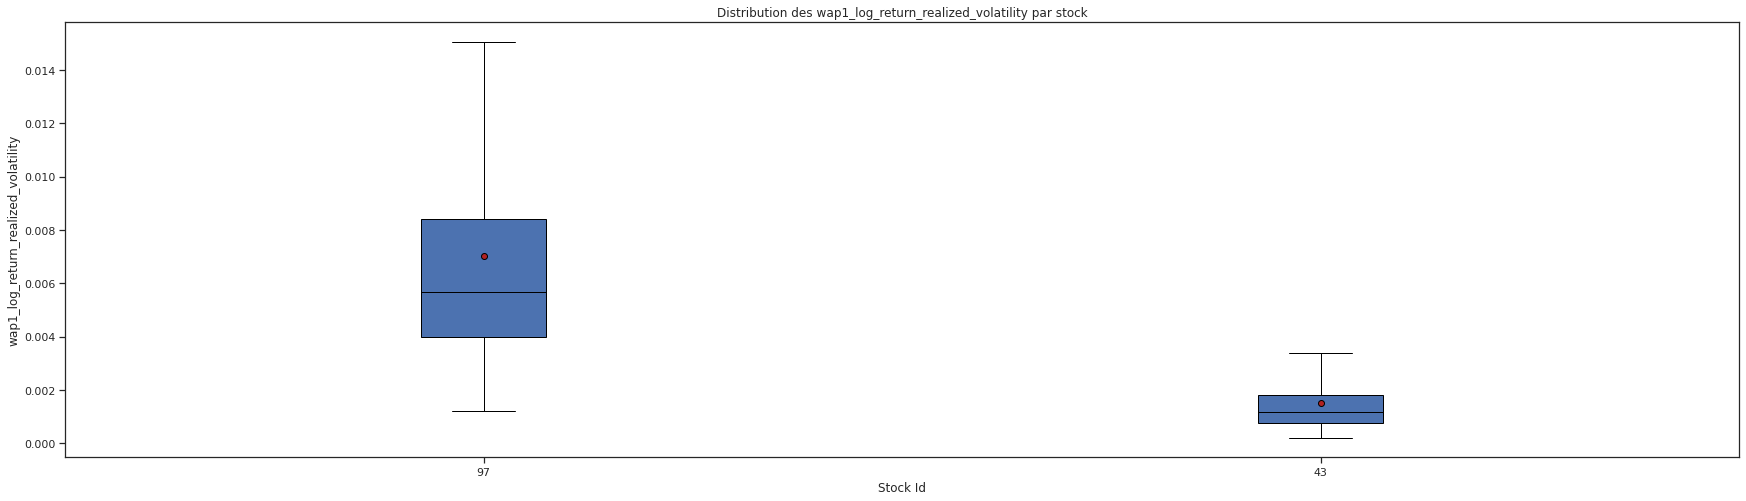

In [37]:
###########################################
# Ploting realized volatility per stock
###########################################

# # Creation of a subsample by modality
groupes = []
for s in df_train['stock_id'].unique():
    groupes.append(df_train[df_train['stock_id'] == s]['wap1_log_return_realized_volatility'])
 
# 'OO' méthode pour plot
fig, ax = plt.subplots(figsize=(30,8))

# Propriétés graphiques
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

ax.boxplot(groupes,
           labels=df_train['stock_id'].unique(),
           showfliers=False,
           medianprops=medianprops, 
           vert=True,
           patch_artist=True,
           showmeans=True,
           meanprops=meanprops)

ax.set(title='Distribution des wap1_log_return_realized_volatility par stock',
      xlabel="Stock Id",
      ylabel='wap1_log_return_realized_volatility')

plt.show()

## Test dataset


In [38]:
# list of test books paths
list_order_book_file_test = glob.glob(data_folder + bk_test_fol + '*')
list_order_trade_file_test = glob.glob(data_folder + td_test_fol + '*')

# preprocess test dataset
df_order_test_agg = agg_df_and_concatenate_parallel(list_order_book_file_test, book_agg_form_parallele)
df_trade_test_agg = agg_df_and_concatenate_parallel(list_order_trade_file_test, trade_agg_form_parallele)

# Merging df
df_test = process_final_df(df_order_test_agg, df_trade_test_agg, vol_test)
df_test.head()

,stock_id,time_id,row_id,wap1_log_return_realized_volatility,diff_wap1_20sec_EWM_sum,diff_wap1_20sec_EWM_std,diff_wap1_100sec_EWM_sum,diff_wap1_100sec_EWM_std,wap2_log_return_realized_volatility,diff_wap2_20sec_EWM_sum,diff_wap2_20sec_EWM_std,diff_wap2_100sec_EWM_sum,diff_wap2_100sec_EWM_std,wap1_ns_log_return_realized_volatility,diff_wap1_ns_20sec_EWM_sum,diff_wap1_ns_20sec_EWM_std,diff_wap1_ns_100sec_EWM_sum,diff_wap1_ns_100sec_EWM_std,wap2_ns_log_return_realized_volatility,diff_wap2_ns_20sec_EWM_sum,diff_wap2_ns_20sec_EWM_std,diff_wap2_ns_100sec_EWM_sum,diff_wap2_ns_100sec_EWM_std,wap_p_log_return_realized_volatility,diff_wap_p_20sec_EWM_sum,diff_wap_p_20sec_EWM_std,diff_wap_p_100sec_EWM_sum,diff_wap_p_100sec_EWM_std,bid_ask_spread1_sum,bid_ask_spread1_std,bid_ask_spread2_sum,bid_ask_spread2_std,bid_ask_spread_p_sum,bid_ask_spread_p_std,bid_spread_sum,bid_spread_std,ask_spread_sum,ask_spread_std,price_spread_sum,price_spread_std,total_volume_sum,total_volume_mean,volume_imbalance_std,wap_balance_sum,wap_balance_mean,amount_20sec_EWM_log_return_realized_volatility,amount_100sec_EWM_log_return_realized_volatility,td_log_return_realized_volatility,diff_td_std,amount_p_order_mean,amount_p_order_sum,price_mean,amount_std,amount_mad,order_count_mean,order_count_sum
0,0,4,0-4,0.000329,0.000266,0.000154,0.000289,0.000167,0.000288,0.000272,0.000137,0.000297,0.00015,0.000274,0.000222,0.000128,0.00024,0.000139,0.000031,0.00005,0.000014,0.000056,0.000016,0.000296,0.000254,0.00014,0.000276,0.000152,0.001672,0.000028,0.003197,0.000142,0.002434,0.000085,0.00118,0.0,-0.000344,0.000113,0.001671,0.000028,1052,350.666667,165.711597,0.000436,0.000145,2.419283,1.194859,0.000295,9.899495,23.810858,47.621716,1.000054,0.0007,0.000495,5,10


# Machine learning

---


### Functions and variables


In [39]:
# For optuna studies
n_trials = 5

kfolds = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

scorer_rmspe = make_scorer(rmspe,
    # greater_is_better=False
    )

In [40]:
dic_eval = {}
def evaluate(name, model, dic, X_test, y_test):
    y_pred = model.predict(X_test)
    R2 = round(r2_score(y_test, y_pred), 6)
    RMSPE = round(rmspe(y_test, y_pred), 6)
    dic[name] = [model, RMSPE, R2]
    print(f'Performance of the {name} prediction: R2 score: {R2}, RMSPE: {RMSPE}')

def evaluateCV(name, model, dic, X_train, y_train, save=True):
    start_time = time.time()
    RMSPE =  round(cross_val_score(
        model, X_train, y_train, cv=kfolds, scoring=scorer_rmspe
    ).mean(), 6)
    
    if save:
        dic[name] = [model, RMSPE]
    print(f'RMSPE of the {name} prediction: {RMSPE} in {round(time.time() - start_time, 3)} sec.')
    if not(save):
        return RMSPE

### Dataset


In [41]:
df_train.head()

,stock_id,time_id,target,row_id,wap1_log_return_realized_volatility,diff_wap1_20sec_EWM_sum,diff_wap1_20sec_EWM_std,diff_wap1_100sec_EWM_sum,diff_wap1_100sec_EWM_std,wap2_log_return_realized_volatility,diff_wap2_20sec_EWM_sum,diff_wap2_20sec_EWM_std,diff_wap2_100sec_EWM_sum,diff_wap2_100sec_EWM_std,wap1_ns_log_return_realized_volatility,diff_wap1_ns_20sec_EWM_sum,diff_wap1_ns_20sec_EWM_std,diff_wap1_ns_100sec_EWM_sum,diff_wap1_ns_100sec_EWM_std,wap2_ns_log_return_realized_volatility,diff_wap2_ns_20sec_EWM_sum,diff_wap2_ns_20sec_EWM_std,diff_wap2_ns_100sec_EWM_sum,diff_wap2_ns_100sec_EWM_std,wap_p_log_return_realized_volatility,diff_wap_p_20sec_EWM_sum,diff_wap_p_20sec_EWM_std,diff_wap_p_100sec_EWM_sum,diff_wap_p_100sec_EWM_std,bid_ask_spread1_sum,bid_ask_spread1_std,bid_ask_spread2_sum,bid_ask_spread2_std,bid_ask_spread_p_sum,bid_ask_spread_p_std,bid_spread_sum,bid_spread_std,ask_spread_sum,ask_spread_std,price_spread_sum,price_spread_std,total_volume_sum,total_volume_mean,volume_imbalance_std,wap_balance_sum,wap_balance_mean,amount_20sec_EWM_log_return_realized_volatility,amount_100sec_EWM_log_return_realized_volatility,td_log_return_realized_volatility,diff_td_std,amount_p_order_mean,amount_p_order_sum,price_mean,amount_std,amount_mad,order_count_mean,order_count_sum
0,97,5,0.006254,97-5,0.007263,0.146303,0.000420,0.274399,0.000807,0.012585,0.191627,0.000542,0.314903,0.000804,0.008643,0.147078,0.000465,0.254380,0.000857,0.010847,0.173970,0.000611,0.306562,0.001029,0.007990,0.138179,0.000439,0.274364,0.000749,0.422247,0.000389,0.569156,0.000640,0.495690,0.000457,0.048495,0.000278,-0.098261,0.000393,0.421913,0.000388,118424,415.522807,108.259034,0.205782,0.000722,0.644652,0.131968,0.004278,16.484140,27.392197,1040.903442,1.001283,111.925492,83.106712,3.447368,131.0
1,97,11,0.002656,97-11,0.002919,0.066503,0.000275,0.129559,0.000334,0.005377,0.077122,0.000246,0.126430,0.000373,0.002599,0.048111,0.000256,0.100007,0.000310,0.005923,0.087057,0.000335,0.114985,0.000354,0.002823,0.064529,0.000237,0.118892,0.000319,0.195123,0.000216,0.272412,0.000244,0.233766,0.000214,0.030290,0.000121,-0.046888,0.000166,0.195038,0.000216,83580,346.804979,135.441451,0.096073,0.000399,0.753227,0.150204,0.001639,25.865840,14.503800,348.091217,0.999108,156.253897,92.918365,3.583333,86.0
2,97,16,0.003712,97-16,0.003799,0.090183,0.000332,0.166598,0.000374,0.006038,0.116412,0.000367,0.194114,0.000456,0.004054,0.088901,0.000345,0.157622,0.000450,0.005771,0.100851,0.000353,0.146179,0.000453,0.003888,0.095898,0.000333,0.178174,0.000383,0.174843,0.000238,0.284401,0.000341,0.229612,0.000260,0.059152,0.000182,-0.050283,0.000200,0.174782,0.000238,144777,500.958478,295.533830,0.077268,0.000267,1.460146,0.280070,0.002517,12.963660,54.467304,2777.832520,0.999860,179.858867,115.586800,2.117647,108.0
3,97,31,0.005743,97-31,0.003753,0.070969,0.000282,0.098221,0.000390,0.007352,0.095455,0.000309,0.118228,0.000404,0.005619,0.095409,0.000359,0.157294,0.000416,0.007742,0.109555,0.000415,0.159722,0.000537,0.004224,0.066110,0.000257,0.097760,0.000331,0.252483,0.000419,0.389376,0.000587,0.320917,0.000470,0.048572,0.000226,-0.088110,0.000290,0.252322,0.000418,88588,393.724444,140.207786,0.126249,0.000561,0.497730,0.148103,0.002241,19.761663,27.598328,689.958191,0.999670,177.576791,134.469025,4.200000,105.0
4,97,62,0.005345,97-62,0.004365,0.058954,0.000258,0.086390,0.000363,0.006709,0.071939,0.000404,0.113838,0.000447,0.006307,0.090235,0.000420,0.126327,0.000595,0.006824,0.081547,0.000361,0.107275,0.000519,0.004028,0.058798,0.000261,0.095513,0.000334,0.227878,0.000566,0.321658,0.000646,0.274759,0.000570,0.043546,0.000243,-0.049991,0.000306,0.227696,0.000565,86193,516.125749,98.150079,0.082689,0.000495,0.331848,0.080810,0.002836,25.141495,33.695877,606.525757,0.999190,131.474313,99.819061,3.611111,65.0


In [42]:
df_train.isnull().sum()

stock_id                                            0
time_id                                             0
target                                              0
row_id                                              0
wap1_log_return_realized_volatility                 0
diff_wap1_20sec_EWM_sum                             0
diff_wap1_20sec_EWM_std                             0
diff_wap1_100sec_EWM_sum                            0
diff_wap1_100sec_EWM_std                            0
wap2_log_return_realized_volatility                 0
diff_wap2_20sec_EWM_sum                             0
diff_wap2_20sec_EWM_std                             0
diff_wap2_100sec_EWM_sum                            0
diff_wap2_100sec_EWM_std                            0
wap1_ns_log_return_realized_volatility              0
diff_wap1_ns_20sec_EWM_sum                          0
diff_wap1_ns_20sec_EWM_std                          0
diff_wap1_ns_100sec_EWM_sum                         0
diff_wap1_ns_100sec_EWM_std 

### Scalers


In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer


qtn = QuantileTransformer(output_distribution='normal', random_state=42)
qtu = QuantileTransformer(output_distribution='uniform', random_state=42)
std = StandardScaler()
minmax = MinMaxScaler()

scalers = [qtn, qtu, std, minmax]

In [44]:
def scaler_selection(scalers):
    rmspe_min = 1
    for scaler in scalers:
        X = df_train.drop(['row_id', 'target'], axis = 1)
        y = df_train['target']

        X_train, X_test, y_train, y_test = train_test_split(X, y,
        test_size=0.15, random_state=42, shuffle=True)

        
        if env == 'kaggle':
            model_xgb = make_pipeline(scaler,
            XGBRegressor(tree_method='gpu_hist', random_state=42, n_jobs= - 1))
        else:
            model_xgb = make_pipeline(scaler,
                XGBRegressor(tree_method='hist', random_state=42, n_jobs= - 1))

       
        rmspe_model = evaluateCV('XGBOOST_'+ str(scaler), model_xgb, dic_eval, X_train, y_train, save=False)

    
        if rmspe_model < rmspe_min:
            rmspe_min = rmspe_model
            selected_scaler = scaler

    return selected_scaler, rmspe_min

selected_scaler, rmspe_scaler = scaler_selection(scalers)
print(f'the selected scaler is {selected_scaler}')

RMSPE of the XGBOOST_QuantileTransformer(output_distribution='normal', random_state=42) prediction: 0.288003 in 3.061 sec.
RMSPE of the XGBOOST_QuantileTransformer(random_state=42) prediction: 0.292443 in 1.573 sec.
RMSPE of the XGBOOST_StandardScaler() prediction: 0.292443 in 0.988 sec.
RMSPE of the XGBOOST_MinMaxScaler() prediction: 0.292443 in 0.976 sec.
the selected scaler is QuantileTransformer(output_distribution='normal', random_state=42)


### Train values


In [45]:
X_train = df_train.drop(['row_id', 'target'], axis = 1)
y_train = df_train['target']

X_train.shape, y_train.shape

((7660, 55), (7660,))

### Test values


In [46]:
X_test = df_test.drop(['row_id'], axis = 1)
df_pred = df_test[['row_id']]

In [47]:
def tune(objective, n_trials=n_trials):
    start_time = time.time()
    study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(objective, n_trials=n_trials, gc_after_trial=True)

    params = study.best_params
    print("--- %s seconds ---" % (time.time() - start_time))
    return params

## Lasso

---


In [48]:
def lasso_objective(trial):
    _alpha = trial.suggest_loguniform("alpha", 0.0001, 10)
    lasso = Lasso(alpha=_alpha, random_state=RANDOM_SEED)

    score = cross_val_score(
        lasso, X_train, y_train, cv=kfolds, scoring=scorer_rmspe
    ).mean()
    return score

In [49]:
lasso_params = tune(lasso_objective, n_trials=5) # long and results are bad
lasso_opt = Lasso(**lasso_params, random_state=RANDOM_SEED)

[I 2023-11-21 06:24:16,530] A new study created in memory with name: no-name-d85b1ff2-65e5-49a2-b6e8-d27986734aeb
[I 2023-11-21 06:24:16,874] Trial 0 finished with value: 1.2773551230023028 and parameters: {'alpha': 0.15620500578940077}. Best is trial 0 with value: 1.2773551230023028.
[I 2023-11-21 06:24:17,495] Trial 1 finished with value: 1.2240638430915372 and parameters: {'alpha': 0.049977753330078686}. Best is trial 1 with value: 1.2240638430915372.
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02033171279310704, tolerance: 8.048180543502867e-06
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02015104871998171, tolerance: 8.01484104480517e-06
  positive)
/opt/c

--- 4.338069200515747 seconds ---


In [50]:
evaluateCV('Lasso', lasso_opt, dic_eval, X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02033171279310704, tolerance: 8.048180543502867e-06
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02015104871998171, tolerance: 8.01484104480517e-06
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018580820035324373, tolerance: 7.727834283383592e-06
  positive)


RMSPE of the Lasso prediction: 0.995591 in 1.818 sec.


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010253458873596466, tolerance: 7.926157788730375e-06
  positive)


## RandomForrest


In [51]:
def randomforest_objectiveCV(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 200)
    _max_depth = trial.suggest_int("max_depth", 5, 20)
    _min_samp_split = trial.suggest_int("min_samples_split", 2, 10)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 10)

    rf = RandomForestRegressor(
        max_depth=_max_depth,
        min_samples_split=_min_samp_split,
        min_samples_leaf=_min_samples_leaf,
        n_estimators=_n_estimators,
        n_jobs=-1,
        random_state=RANDOM_SEED,
    )
    score = cross_val_score(
        rf, X_train, y_train, cv=kfolds, scoring=scorer_rmspe
    ).mean()
    return score

In [52]:
randomforest_params = tune(randomforest_objectiveCV, n_trials=5) # long, average results...
rf_opt = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_SEED, **randomforest_params)

[I 2023-11-21 06:24:22,720] A new study created in memory with name: no-name-70bb8d63-aa05-47bc-bc32-48e2f3e79b35
[I 2023-11-21 06:25:22,074] Trial 0 finished with value: 0.2545886796589259 and parameters: {'n_estimators': 170, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.2545886796589259.
[I 2023-11-21 06:25:52,441] Trial 1 finished with value: 0.256165360950536 and parameters: {'n_estimators': 136, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.2545886796589259.
[I 2023-11-21 06:26:57,863] Trial 2 finished with value: 0.2558541274942229 and parameters: {'n_estimators': 176, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.2545886796589259.
[I 2023-11-21 06:27:55,534] Trial 3 finished with value: 0.2574137923697852 and parameters: {'n_estimators': 146, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 0 with value: 

--- 233.74321150779724 seconds ---


In [53]:
evaluateCV('RandomForrest', rf_opt, dic_eval, X_train, y_train)

RMSPE of the RandomForrest prediction: 0.254589 in 57.47 sec.


## Basic XGB model

---


In [54]:
def plot_feature_importance(df_train, model, name=None):

    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,df_train.columns)), columns=['Value','Feature'])

    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('Features importance')
    plt.tight_layout()
    if (env == 'local' or env == 'kaggle') and name is not None:
        plt.savefig(save_path + name +'_feat_imp.png')
    plt.show()

In [55]:
if env == 'kaggle':
    xgb = XGBRegressor(tree_method='gpu_hist', random_state=42, n_jobs= - 1)
else:
    xgb = XGBRegressor(tree_method='hist', random_state=42, n_jobs= - 1)

In [56]:
evaluateCV('XGBOOST', xgb, dic_eval, X_train, y_train)

RMSPE of the XGBOOST prediction: 0.289397 in 1.057 sec.


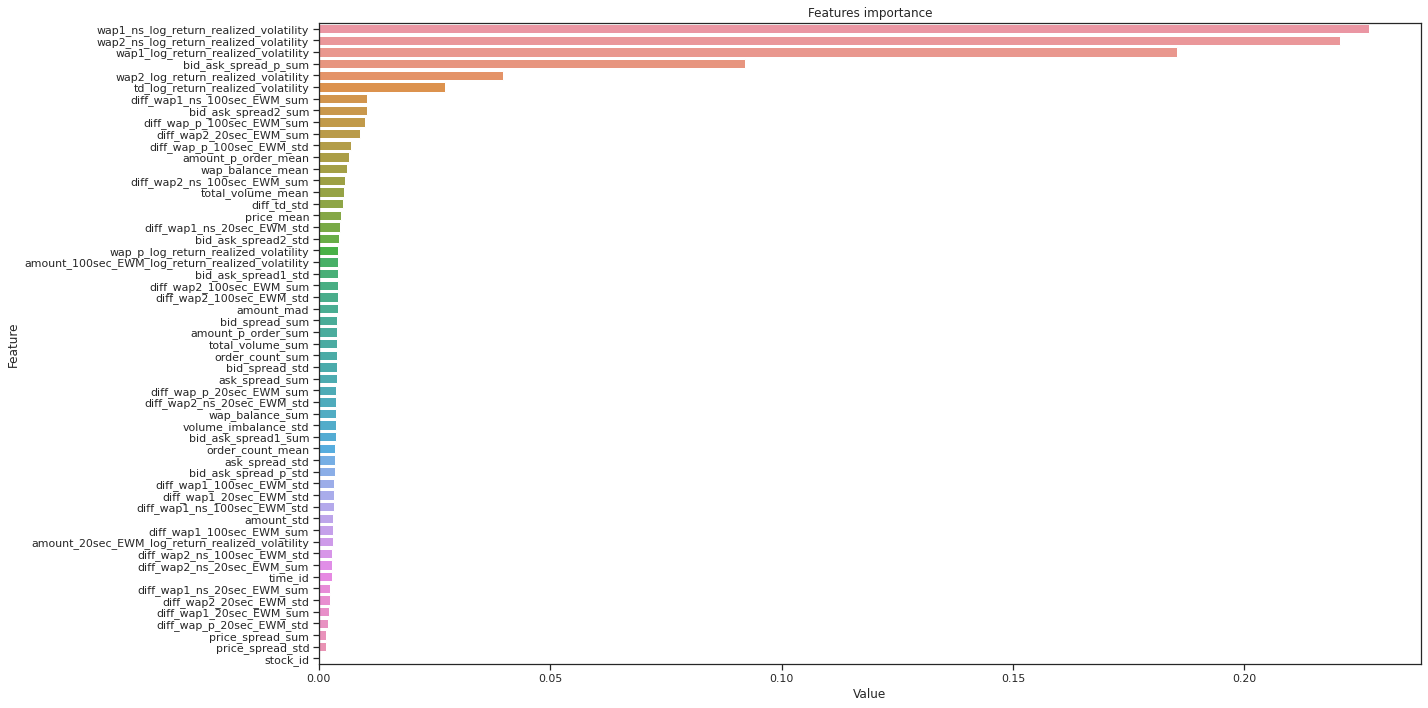

In [57]:
xgb.fit(X_train, y_train)
plot_feature_importance(X_train, xgb, 'xgb')

## Basic LGBMRegressor model


In [58]:
if env == 'kaggle':
    lgbm = LGBMRegressor(device='gpu', random_state=42)
else:
    lgbm = LGBMRegressor(device='cpu', random_state=42)


In [59]:
evaluateCV('LIGHTGBM', lgbm, dic_eval, X_train, y_train)

RMSPE of the LIGHTGBM prediction: 0.260617 in 8.605 sec.


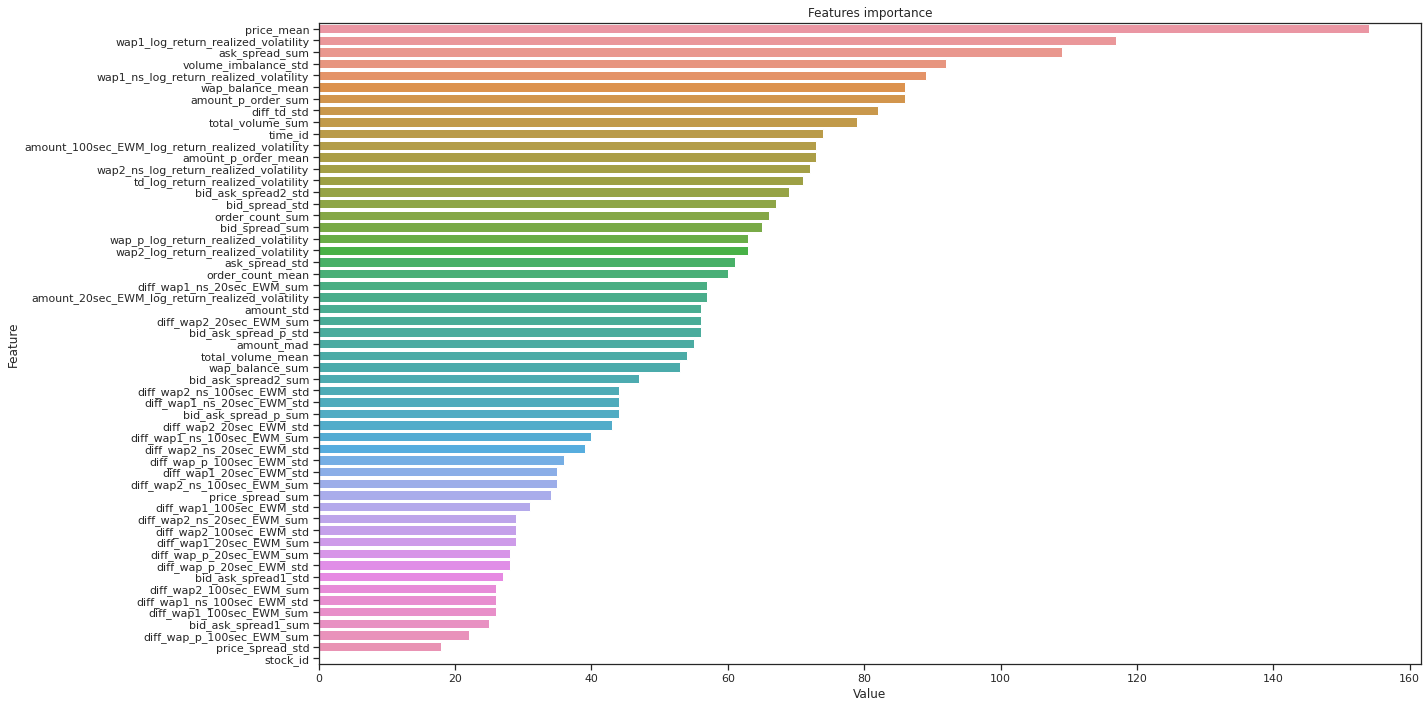

In [60]:
lgbm.fit(X_train, y_train)
plot_feature_importance(X_train, lgbm, 'lgbm')

## Removing useless features


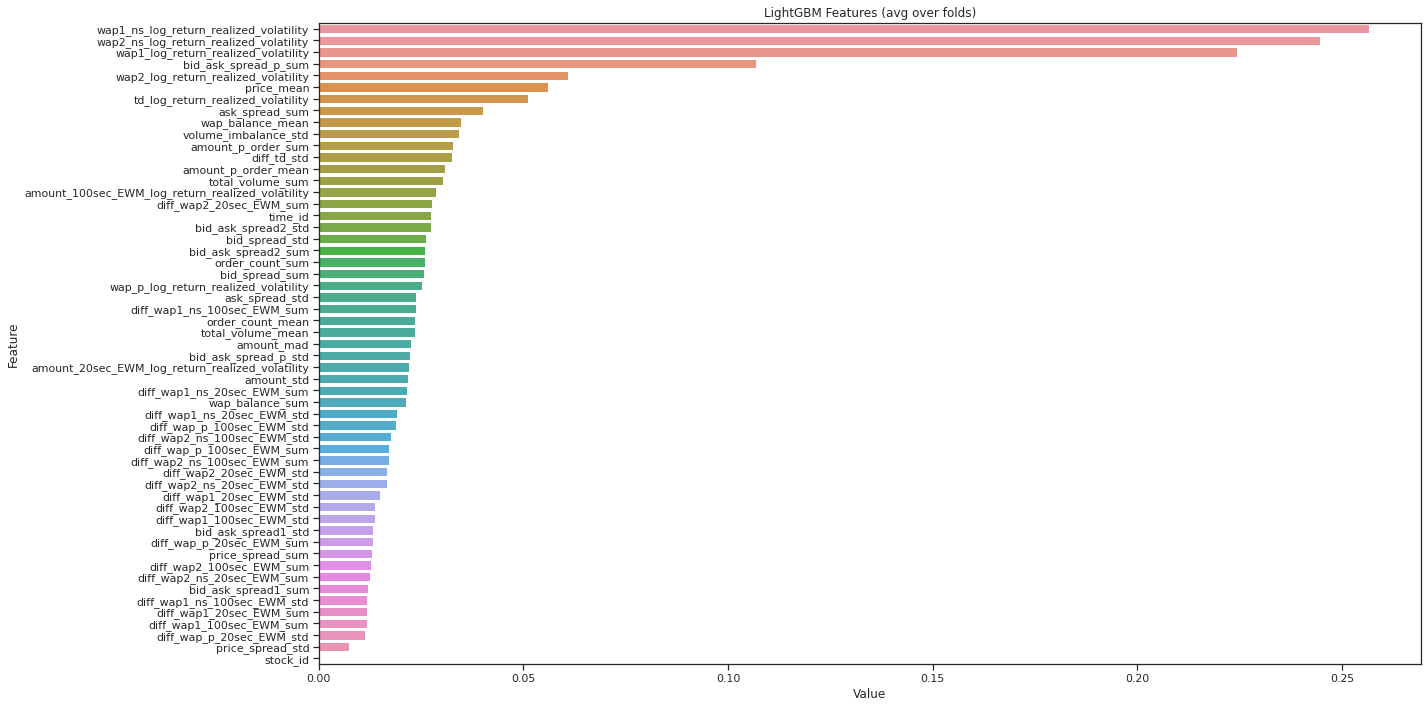

In [61]:
features_imp_lgbm_xgb = [x/sum(lgbm.feature_importances_) + y/sum(xgb.feature_importances_) for x, y in zip(lgbm.feature_importances_, xgb.feature_importances_)] 
feature_imp = pd.DataFrame(sorted(zip(features_imp_lgbm_xgb,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()


## CatBoost


In [62]:
cbr = CatBoostRegressor(iterations=500, random_seed=42)
evaluateCV('catboost', cbr, dic_eval, X_train, y_train)

Learning rate set to 0.09127
0:	learn: 0.0033097	total: 66.8ms	remaining: 33.3s
1:	learn: 0.0030736	total: 75.3ms	remaining: 18.8s
2:	learn: 0.0028587	total: 83.7ms	remaining: 13.9s
3:	learn: 0.0026715	total: 92ms	remaining: 11.4s
4:	learn: 0.0025041	total: 101ms	remaining: 10s
5:	learn: 0.0023477	total: 109ms	remaining: 8.99s
6:	learn: 0.0022100	total: 117ms	remaining: 8.27s
7:	learn: 0.0020887	total: 126ms	remaining: 7.75s
8:	learn: 0.0019819	total: 135ms	remaining: 7.34s
9:	learn: 0.0018827	total: 144ms	remaining: 7.06s
10:	learn: 0.0018018	total: 153ms	remaining: 6.8s
11:	learn: 0.0017280	total: 162ms	remaining: 6.58s
12:	learn: 0.0016615	total: 171ms	remaining: 6.39s
13:	learn: 0.0016028	total: 180ms	remaining: 6.24s
14:	learn: 0.0015505	total: 188ms	remaining: 6.09s
15:	learn: 0.0015079	total: 198ms	remaining: 6s
16:	learn: 0.0014708	total: 206ms	remaining: 5.87s
17:	learn: 0.0014362	total: 215ms	remaining: 5.75s
18:	learn: 0.0014083	total: 223ms	remaining: 5.64s
19:	learn: 0.001

## Optuna Tuned XGBoost


Optuna will allow us to find our best hyperparameters.
It will then be enough to train our model with these parameters to evaluate it.


In [63]:
def objective_xgbCV(trial):

    param = {
            'alpha': trial.suggest_loguniform('alpha', 1e-3, 1),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9]),
            'subsample': trial.suggest_categorical('subsample', [0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
            'n_estimators': trial.suggest_int('n_estimators', 500, 3000),
            }

    if env == 'kaggle':
        param['tree_method'] = 'gpu_hist'
    else:
        param['tree_method'] = 'hist'
    
    model = XGBRegressor(**param, random_state=42)

    score = cross_val_score(
        model, X_train, y_train, cv=kfolds, scoring=scorer_rmspe
    ).mean()
    return score

In [64]:
%%time
study_xgb = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study_xgb.optimize(objective_xgbCV, n_trials=n_trials, gc_after_trial=True)

[I 2023-11-21 06:29:55,794] A new study created in memory with name: no-name-5fb9ffa3-b4a4-440d-ae61-d30af057682b
[I 2023-11-21 06:30:15,841] Trial 0 finished with value: 0.2674108535687659 and parameters: {'alpha': 0.012510163415768293, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.016, 'n_estimators': 1741}. Best is trial 0 with value: 0.2674108535687659.
[I 2023-11-21 06:30:55,212] Trial 1 finished with value: 0.2604019496080518 and parameters: {'alpha': 0.0011254290696191824, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.009, 'n_estimators': 2824}. Best is trial 1 with value: 0.2604019496080518.
[I 2023-11-21 06:31:06,583] Trial 2 finished with value: 0.26270227203896357 and parameters: {'alpha': 0.0014335606190017658, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'n_estimators': 1537}. Best is trial 1 with value: 0.2604019496080518.
[I 2023-11-21 06:31:15,886] Trial 3 finished with value: 0.4086793039839714 and parameters: {'alp

CPU times: user 1min 31s, sys: 656 ms, total: 1min 32s
Wall time: 1min 28s


In [65]:
print('Number of finished trials:', len(study_xgb.trials))
print('Best trial:', study_xgb.best_trial.params)

Number of finished trials: 5
Best trial: {'alpha': 0.0011254290696191824, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.009, 'n_estimators': 2824}


In [66]:
optuna.visualization.plot_optimization_history(study_xgb)

In [67]:
optuna.visualization.plot_param_importances(study_xgb)

In [68]:
best_xgbparams = study_xgb.best_params
best_xgbparams

{'alpha': 0.0011254290696191824,
 'colsample_bytree': 0.6,
 'subsample': 0.7,
 'learning_rate': 0.009,
 'n_estimators': 2824}

In [69]:
if env == 'Kaggle':
    xgb_opt = XGBRegressor(**best_xgbparams, tree_method='gpu_hist')
else:
    xgb_opt = XGBRegressor(**best_xgbparams, tree_method='hist', n_jobs= - 1)

In [70]:
evaluateCV('XGB_opt', xgb_opt, dic_eval, X_train, y_train)

RMSPE of the XGB_opt prediction: 0.259797 in 85.168 sec.


## Optuna Tuned LGBM


In [71]:
def objective_lgbmCV(trial):
        param = {
                "metric": "rmse",
                "verbosity": -1,
                'learning_rate':trial.suggest_loguniform('learning_rate', 0.005, 0.5),
                "max_depth": trial.suggest_int("max_depth", 2, 500),
                # "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
                # "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
                "num_leaves": trial.suggest_int("num_leaves", 2, 256),
                "n_estimators": trial.suggest_int("n_estimators", 100, 4000),
        #         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 100000, 700000),
                # "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
                "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
                "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
                "min_child_samples": trial.suggest_int("min_child_samples", 5, 100)}

        if env == 'kaggle':
                param["device"] = "gpu"
        else:
                param["device"] = "cpu"

        # pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse")
        model = LGBMRegressor(**param, random_state=42)

        score = cross_val_score(
        # model, X_train, y_train, cv=kfolds, scoring=scorer_rmspe, fit_params={'callbacks': [pruning_callback]}
        # ).mean()
        model, X_train, y_train, cv=kfolds, scoring=scorer_rmspe).mean()
        return score

In [72]:
%%time
study_lgbm = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study_lgbm.optimize(objective_lgbmCV, n_trials=n_trials, gc_after_trial=True) # n_jobs=-1 make the calcul longer !

[I 2023-11-21 06:32:50,496] A new study created in memory with name: no-name-69d1703f-64a5-4618-898c-6f0da518ea4a


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8698135774032041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8698135774032041
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8698135774032041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8698135774032041
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8698135774032041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8698135774032041
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8698135774032041, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2023-11-21 06:34:43,318] Trial 0 finished with value: 0.29005352484939156 and parameters: {'learning_rate': 0.12217998392378561, 'max_depth': 264, 'num_leaves': 241, 'n_estimators': 2309, 'bagging_fraction': 0.8698135774032041, 'bagging_freq': 5, 'min_child_samples': 77}. Best is trial 0 with value: 0.29005352484939156.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7508997155205918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7508997155205918
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7508997155205918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7508997155205918
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7508997155205918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7508997155205918
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7508997155205918, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2023-11-21 06:35:49,092] Trial 1 finished with value: 0.3274392081090517 and parameters: {'learning_rate': 0.49454640276659056, 'max_depth': 340, 'num_leaves': 46, 'n_estimators': 1540, 'bagging_fraction': 0.7508997155205918, 'bagging_freq': 5, 'min_child_samples': 48}. Best is trial 0 with value: 0.29005352484939156.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.44385760400397645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44385760400397645
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.44385760400397645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44385760400397645
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.44385760400397645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44385760400397645
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.44385760400397645, subsample=1.0 will be ignored. Current value: bagging_f

[I 2023-11-21 06:37:53,249] Trial 2 finished with value: 0.28526620581359363 and parameters: {'learning_rate': 0.04766105104098693, 'max_depth': 44, 'num_leaves': 43, 'n_estimators': 3996, 'bagging_fraction': 0.44385760400397645, 'bagging_freq': 2, 'min_child_samples': 100}. Best is trial 2 with value: 0.28526620581359363.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6566581364337436
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6566581364337436
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6566581364337436
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2023-11-21 06:39:08,470] Trial 3 finished with value: 0.26769606121110767 and parameters: {'learning_rate': 0.026798071698755213, 'max_depth': 334, 'num_leaves': 72, 'n_estimators': 1715, 'bagging_fraction': 0.6566581364337436, 'bagging_freq': 2, 'min_child_samples': 79}. Best is trial 3 with value: 0.26769606121110767.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.7877064395726557, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7877064395726557
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.7877064395726557, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7877064395726557
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.7877064395726557, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7877064395726557
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.7877064395726557, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2023-11-21 06:40:13,727] Trial 4 finished with value: 0.3103190146637831 and parameters: {'learning_rate': 0.3670737705458684, 'max_depth': 237, 'num_leaves': 46, 'n_estimators': 1577, 'bagging_fraction': 0.7877064395726557, 'bagging_freq': 6, 'min_child_samples': 77}. Best is trial 3 with value: 0.26769606121110767.


CPU times: user 27min 22s, sys: 1min 26s, total: 28min 49s
Wall time: 7min 23s


In [73]:
print('Number of finished trials:', len(study_lgbm.trials))
print('Best trial:', study_lgbm.best_trial.params)

Number of finished trials: 5
Best trial: {'learning_rate': 0.026798071698755213, 'max_depth': 334, 'num_leaves': 72, 'n_estimators': 1715, 'bagging_fraction': 0.6566581364337436, 'bagging_freq': 2, 'min_child_samples': 79}


In [74]:
optuna.visualization.plot_optimization_history(study_lgbm)

In [75]:
optuna.visualization.plot_param_importances(study_lgbm)


In [76]:
best_lgbmparams = study_lgbm.best_params
best_lgbmparams

{'learning_rate': 0.026798071698755213,
 'max_depth': 334,
 'num_leaves': 72,
 'n_estimators': 1715,
 'bagging_fraction': 0.6566581364337436,
 'bagging_freq': 2,
 'min_child_samples': 79}

In [77]:
# best_lgbmparams = {'learning_rate': 0.012206112226610026,
#     'max_depth': 176,
#     'lambda_l1': 0.0911256640760148,
#     'lambda_l2': 7.619751773104654e-07,
#     'num_leaves': 87,
#     'n_estimators': 2713,
#     'feature_fraction': 0.6744552501464487,
#     'bagging_fraction': 0.7249343934370382,
#     'bagging_freq': 7,
#     'min_child_samples': 53}

if env == 'Kaggle':
    lgbm_opt = LGBMRegressor(**best_lgbmparams, device='gpu')
else:
    lgbm_opt = LGBMRegressor(**best_lgbmparams, device='cpu')


In [78]:
evaluateCV('LIGHTGBM_opt', lgbm_opt, dic_eval, X_train, y_train)

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6566581364337436
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6566581364337436
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6566581364337436
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction

## Stacking Regressor

Stack of estimators with a final regressor.


Stacked generalization consists in stacking the output of individual estimator and use a regressor to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.


In [79]:
if env == 'kaggle':
    tree_method='gpu_hist'
    device='gpu'
    n_jobs=None
else:
    tree_method='hist'
    device='cpu'
    n_jobs=-1

xgb = XGBRegressor(tree_method=tree_method, random_state = RANDOM_SEED)
lgbm = LGBMRegressor(device=device, random_state=RANDOM_SEED)

estimators = [('lgbm_opt', lgbm_opt),
            ('xgb_opt', xgb_opt),
            ('lgbm', lgbm),
            ('xgb', xgb)]

stack_reg = StackingRegressor(estimators=estimators, final_estimator=None, verbose=1, n_jobs=n_jobs)

In [80]:
evaluateCV('Stack_reg', stack_reg, dic_eval, X_train, y_train)

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6566581364337436


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6566581364337436
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6566581364337436
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6566581364337436
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   28.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6566581364337436


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6566581364337436
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6566581364337436
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6566581364337436
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   28.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6566581364337436


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6566581364337436
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6566581364337436
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6566581364337436
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   28.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6566581364337436


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6566581364337436
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6566581364337436
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6566581364337436
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6566581364337436


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6566581364337436
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6566581364337436
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6566581364337436
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6566581364337436, subsample=1.0 will be ignored. Current value: bagging_fraction

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   28.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished


RMSPE of the Stack_reg prediction: 0.822242 in 644.897 sec.


## Scaler on best model

In [81]:
def model_selection(dic):
    rmspe_max = 0
    selected_model = None
    selected_name = None
    
    for key, value in dic.items():
        rmspe_model = value[1]
        if rmspe_model > rmspe_max:
            rmspe_max = rmspe_model
            selected_model = value[0]
            selected_name = key
    
    return selected_model, selected_name

## Score visualization


In [82]:
models = [k for k in dic_eval.keys()]
rmspe_scores = [val[1] for val in dic_eval.values()]

rmspe_scores, models = (list(t) for t in zip(*sorted(zip(rmspe_scores, models))))

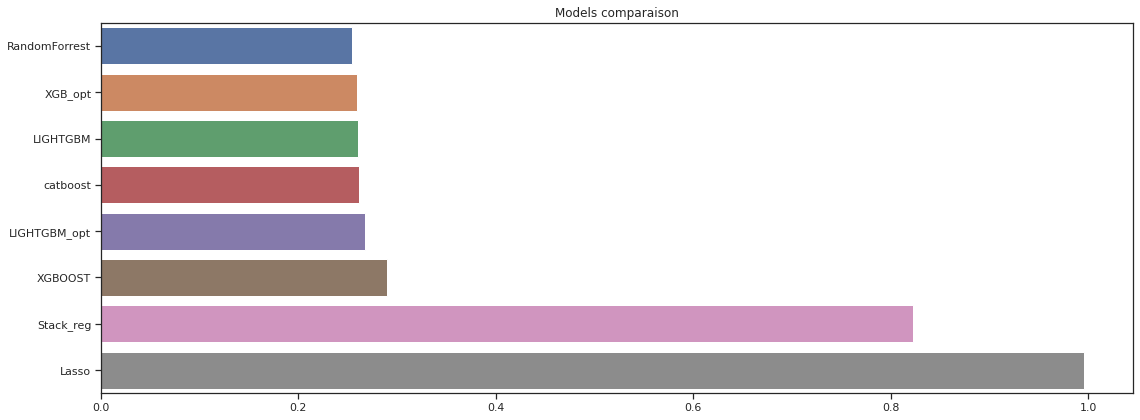

In [83]:
plt.figure(figsize=(16,6))

sns.barplot(x=rmspe_scores, y=models)
plt.title('Models comparaison')
plt.tight_layout()

if (env == 'local' or env == 'kaggle'):
    plt.savefig(save_path + 'models_comparaison.png')
plt.show()
